# Singapore Air Quality Data Cleaning and Processing

This notebook cleans and processes Singapore air quality data (2016-2024) for PM2.5 prediction modeling.

**Data Sources:**
- Pollutants (PM2.5, PM10, O3, CO, SO2, NO2) from data.gov.sg
- Air temperature from weather stations
- Weather forecast data

**Target:** Daily PM2.5 prediction with high-risk threshold at 35 µg/m³ (WHO guidelines)


## Step 1: Environment Setup

Import required libraries and configure the environment.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
from pathlib import Path

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.3.2
NumPy version: 2.3.3


In [2]:
# Set up file paths
base_path = Path('/Users/sharin/Downloads/COS30049/Assignment/Assignment_2/AirAware')
data_path = base_path / 'data' / 'singapore'
output_path = base_path / 'data' / 'singapore'
viz_path = base_path / 'visualizations'

# Create output directories if they don't exist
output_path.mkdir(parents=True, exist_ok=True)
viz_path.mkdir(parents=True, exist_ok=True)

print(f"Base path: {base_path}")
print(f"Data path: {data_path}")
print(f"Output path: {output_path}")
print(f"Visualization path: {viz_path}")

# Verify data directories exist
print("\nData directories:")
for subdir in ['pollutants', 'air_temperature', 'weather_forecast']:
    subdir_path = data_path / subdir
    if subdir_path.exists():
        file_count = len(list(subdir_path.glob('*.csv')))
        print(f"  {subdir}: {file_count} CSV files")
    else:
        print(f"  {subdir}: Directory not found")


Base path: /Users/sharin/Downloads/COS30049/Assignment/Assignment_2/AirAware
Data path: /Users/sharin/Downloads/COS30049/Assignment/Assignment_2/AirAware/data/singapore
Output path: /Users/sharin/Downloads/COS30049/Assignment/Assignment_2/AirAware/data/singapore
Visualization path: /Users/sharin/Downloads/COS30049/Assignment/Assignment_2/AirAware/visualizations

Data directories:
  pollutants: 9 CSV files
  air_temperature: 9 CSV files
  weather_forecast: 9 CSV files


## Step 2: Data Exploration

Examine the structure and quality of raw data files.


In [3]:
# Function to load and explore a sample file
def explore_data_file(file_path, sample_size=5):
    """
    Load and explore a data file
    """
    try:
        df = pd.read_csv(file_path)
        print(f"\n=== {file_path.name} ===")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"\nFirst {sample_size} rows:")
        print(df.head(sample_size))
        print(f"\nData types:")
        print(df.dtypes)
        print(f"\nMissing values:")
        print(df.isnull().sum())
        return df
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Explore sample files from each data source
print("=== DATA EXPLORATION ===")

# Pollutants data
pollutants_file = data_path / 'pollutants' / 'pollutants_2024.csv'
if pollutants_file.exists():
    pollutants_sample = explore_data_file(pollutants_file)

# Air temperature data (check if file exists and is not too large)
temp_file = data_path / 'air_temperature' / 'airtemp_2024.csv'
if temp_file.exists():
    file_size = temp_file.stat().st_size / (1024 * 1024)  # Size in MB
    if file_size < 50:  # Only load if less than 50MB
        temp_sample = explore_data_file(temp_file)
    else:
        print(f"\n=== {temp_file.name} ===")
        print(f"File size: {file_size:.1f} MB - too large to load completely")
        print("Loading first 1000 rows for exploration...")
        temp_sample = pd.read_csv(temp_file, nrows=1000)
        print(f"Shape (first 1000 rows): {temp_sample.shape}")
        print(f"Columns: {list(temp_sample.columns)}")
        print(f"\nFirst 5 rows:")
        print(temp_sample.head())

# Weather forecast data
forecast_file = data_path / 'weather_forecast' / 'forecast_2024.csv'
if forecast_file.exists():
    forecast_sample = explore_data_file(forecast_file)


=== DATA EXPLORATION ===

=== pollutants_2024.csv ===
Shape: (52356, 20)
Columns: ['date', 'timestamp', 'update_timestamp', 'region', 'region_id', 'location_longitude', 'location_latitude', 'pm10_twenty_four_hourly', 'pm10_sub_index', 'pm25_twenty_four_hourly', 'pm25_sub_index', 'o3_eight_hour_max', 'o3_sub_index', 'co_eight_hour_max', 'co_sub_index', 'so2_sub_index', 'so2_twenty_four_hourly', 'no2_one_hour_max', 'psi_twenty_four_hourly', 'psi_three_hourly']

First 5 rows:
         date                  timestamp           update_timestamp   region  \
0  2024-01-01  2024-01-01T00:00:00+08:00  2024-01-01T00:00:41+08:00    south   
1  2024-01-01  2024-01-01T00:00:00+08:00  2024-01-01T00:00:41+08:00    north   
2  2024-01-01  2024-01-01T00:00:00+08:00  2024-01-01T00:00:41+08:00     east   
3  2024-01-01  2024-01-01T00:00:00+08:00  2024-01-01T00:00:41+08:00  central   
4  2024-01-01  2024-01-01T00:00:00+08:00  2024-01-01T00:00:41+08:00     west   

  region_id  location_longitude  location

## Step 3: Pollutants Data Processing

Process pollutants data (PM2.5, PM10, O3, CO, SO2, NO2):
- Normalize timestamps
- Aggregate to daily regional averages
- Handle missing values


In [4]:
def process_pollutants_data(data_path, output_path):
    """
    Process pollutants data from 2016-2024
    - Normalize timestamps
    - Select relevant pollutant columns
    - Aggregate to daily averages by region
    - Handle missing values
    """
    print("=== PROCESSING POLLUTANTS DATA ===")
    
    pollutants_dir = data_path / 'pollutants'
    all_data = []
    
    # Process each year's data
    for year in range(2016, 2025):
        file_path = pollutants_dir / f'pollutants_{year}.csv'
        if file_path.exists():
            print(f"\nProcessing {file_path.name}...")
            try:
                df = pd.read_csv(file_path)
                
                # Convert timestamp to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                
                # Select relevant columns
                columns_to_keep = [
                    'timestamp', 'region', 'pm25_twenty_four_hourly', 
                    'pm10_twenty_four_hourly', 'o3_eight_hour_max', 
                    'co_eight_hour_max', 'so2_twenty_four_hourly', 
                    'no2_one_hour_max'
                ]
                
                # Check which columns exist
                available_columns = [col for col in columns_to_keep if col in df.columns]
                df_subset = df[available_columns].copy()
                
                # Convert pollutant columns to numeric, handling empty strings
                pollutant_cols = [col for col in available_columns if col not in ['timestamp', 'region']]
                for col in pollutant_cols:
                    df_subset[col] = pd.to_numeric(df_subset[col], errors='coerce')
                
                # Filter out national region (we'll handle it separately)
                df_subset = df_subset[df_subset['region'] != 'national'].copy()
                
                # Create date column for daily aggregation
                # Extract date from timestamp (type ignore for linter)
                df_subset['date'] = df_subset['timestamp'].dt.date  # type: ignore
                
                all_data.append(df_subset)
                print(f"  ✓ Loaded {len(df_subset):,} records")
                
            except Exception as e:
                print(f"  ✗ Error processing {file_path.name}: {e}")
        else:
            print(f"File not found: {file_path.name}")
    
    if not all_data:
        print("No pollutants data found!")
        return None
    
    # Combine all years
    print("\n" + "="*50)
    print("Combining all years...")
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Total records: {len(combined_df):,}")
    print(f"Regions: {sorted(combined_df['region'].unique())}")
    
    # Daily aggregation by region
    print("\n" + "="*50)
    print("Performing daily aggregation by region...")
    daily_agg = combined_df.groupby(['region', 'date']).agg({
        'pm25_twenty_four_hourly': 'mean',
        'pm10_twenty_four_hourly': 'mean',
        'o3_eight_hour_max': 'mean',
        'co_eight_hour_max': 'mean',
        'so2_twenty_four_hourly': 'mean',
        'no2_one_hour_max': 'mean'
    }).reset_index()
    
    print(f"Daily aggregated records: {len(daily_agg):,}")
    print(f"Date range: {daily_agg['date'].min()} to {daily_agg['date'].max()}")
    
    # Save processed data
    output_file = output_path / 'pollutants_clean.csv'
    daily_agg.to_csv(output_file, index=False)
    print(f"\n✓ Saved cleaned pollutants data to: {output_file}")
    
    return daily_agg

# Process pollutants data
pollutants_clean = process_pollutants_data(data_path, output_path)


=== PROCESSING POLLUTANTS DATA ===

Processing pollutants_2016.csv...
  ✓ Loaded 35,740 records

Processing pollutants_2017.csv...
  ✓ Loaded 42,475 records

Processing pollutants_2018.csv...
  ✓ Loaded 42,045 records

Processing pollutants_2019.csv...
  ✓ Loaded 41,915 records

Processing pollutants_2020.csv...
  ✓ Loaded 42,315 records

Processing pollutants_2021.csv...
  ✓ Loaded 41,455 records

Processing pollutants_2022.csv...
  ✓ Loaded 42,935 records

Processing pollutants_2023.csv...
  ✓ Loaded 40,445 records

Processing pollutants_2024.csv...
  ✓ Loaded 43,630 records

Combining all years...
Total records: 372,955
Regions: ['central', 'east', 'north', 'south', 'west']

Performing daily aggregation by region...
Daily aggregated records: 15,980
Date range: 2016-02-07 to 2024-12-31

✓ Saved cleaned pollutants data to: /Users/sharin/Downloads/COS30049/Assignment/Assignment_2/AirAware/data/singapore/pollutants_clean.csv


### 3.1 Pollutants Data Summary


In [5]:
# Display summary of cleaned pollutants data
if pollutants_clean is not None:
    print("=== POLLUTANTS DATA SUMMARY ===")
    print(f"Shape: {pollutants_clean.shape}")
    print(f"\nColumns: {list(pollutants_clean.columns)}")
    print(f"\nFirst 10 rows:")
    display(pollutants_clean.head(10))
    
    print(f"\nData types:")
    print(pollutants_clean.dtypes)
    
    print(f"\nMissing values:")
    missing_values = pollutants_clean.isnull().sum()
    missing_pct = (missing_values / len(pollutants_clean) * 100).round(2)
    missing_df = pd.DataFrame({
        'Missing Count': missing_values,
        'Percentage': missing_pct
    })
    display(missing_df)
    
    print(f"\nBasic statistics:")
    display(pollutants_clean.describe())
    
    # Check PM2.5 distribution
    print(f"\n" + "="*50)
    print("PM2.5 STATISTICS (PRIMARY TARGET)")
    print("="*50)
    pm25_stats = pollutants_clean['pm25_twenty_four_hourly'].describe()
    display(pm25_stats)
    
    # Count high-risk days (PM2.5 >= 35)
    high_risk_days = pollutants_clean[pollutants_clean['pm25_twenty_four_hourly'] >= 35]
    total_days = len(pollutants_clean)
    high_risk_count = len(high_risk_days)
    high_risk_pct = (high_risk_count / total_days * 100)
    
    print(f"\nHigh-risk days (PM2.5 >= 35 µg/m³): {high_risk_count:,} out of {total_days:,} ({high_risk_pct:.1f}%)")
    
    # Distribution by region
    print(f"\n" + "="*50)
    print("DISTRIBUTION BY REGION")
    print("="*50)
    region_counts = pollutants_clean.groupby('region').size()
    region_counts_sorted = region_counts.sort_values(ascending=False)  # type: ignore
    print(region_counts_sorted)
else:
    print("Error: Pollutants data could not be processed.")


=== POLLUTANTS DATA SUMMARY ===
Shape: (15980, 8)

Columns: ['region', 'date', 'pm25_twenty_four_hourly', 'pm10_twenty_four_hourly', 'o3_eight_hour_max', 'co_eight_hour_max', 'so2_twenty_four_hourly', 'no2_one_hour_max']

First 10 rows:


,region,date,pm25_twenty_four_hourly,pm10_twenty_four_hourly,o3_eight_hour_max,co_eight_hour_max,so2_twenty_four_hourly,no2_one_hour_max
0,central,2016-02-07,11.000000,21.000000,59.000000,0.450000,3.000000,10.000000
1,central,2016-02-08,17.000000,34.000000,49.000000,0.420000,4.000000,15.000000
2,central,2016-02-09,18.125000,34.291667,51.791667,0.443333,3.083333,7.708333
3,central,2016-02-10,15.500000,26.875000,34.041667,0.447917,3.000000,12.458333
4,central,2016-02-11,7.833333,15.208333,24.541667,0.392500,3.083333,15.875000
5,central,2016-02-12,9.350000,19.800000,19.650000,0.361500,4.000000,21.450000
6,central,2016-02-13,11.333333,20.125000,19.125000,0.387917,4.833333,13.000000
7,central,2016-02-14,9.041667,16.125000,23.958333,0.279583,4.000000,13.833333
8,central,2016-02-15,11.750000,19.500000,24.958333,0.350000,4.000000,14.458333
9,central,2016-02-16,12.260870,22.652174,23.173913,0.312609,4.739130,13.130435



Data types:
region                      object
date                        object
pm25_twenty_four_hourly    float64
pm10_twenty_four_hourly    float64
o3_eight_hour_max          float64
co_eight_hour_max          float64
so2_twenty_four_hourly     float64
no2_one_hour_max           float64
dtype: object

Missing values:


,Missing Count,Percentage
region,0,0.00
date,0,0.00
pm25_twenty_four_hourly,0,0.00
pm10_twenty_four_hourly,0,0.00
o3_eight_hour_max,0,0.00
co_eight_hour_max,812,5.08
so2_twenty_four_hourly,0,0.00
no2_one_hour_max,0,0.00



Basic statistics:


,pm25_twenty_four_hourly,pm10_twenty_four_hourly,o3_eight_hour_max,co_eight_hour_max,so2_twenty_four_hourly,no2_one_hour_max
count,15980.000000,15980.000000,15980.000000,15168.000000,15980.000000,15980.000000
mean,13.051394,26.464170,24.707647,0.536694,7.413112,24.307225
std,5.880390,8.849084,12.108409,0.210914,7.495604,10.907774
min,3.086957,7.208333,2.000000,0.114167,1.000000,2.800000
25%,9.209978,20.333333,15.958333,0.395833,3.000000,16.250000
50%,11.916667,25.291667,22.625000,0.494583,4.791667,23.083333
75%,15.583333,31.125000,31.333333,0.622500,8.750000,30.875000
max,85.250000,118.333333,101.166667,3.443478,112.625000,117.833333



PM2.5 STATISTICS (PRIMARY TARGET)


count    15980.000000
mean        13.051394
std          5.880390
min          3.086957
25%          9.209978
50%         11.916667
75%         15.583333
max         85.250000
Name: pm25_twenty_four_hourly, dtype: float64


High-risk days (PM2.5 >= 35 µg/m³): 111 out of 15,980 (0.7%)

DISTRIBUTION BY REGION
region
central    3196
east       3196
north      3196
south      3196
west       3196
dtype: int64


### 3.2 PM2.5 Distribution Visualizations


✓ Saved visualization to: /Users/sharin/Downloads/COS30049/Assignment/Assignment_2/AirAware/visualizations/singapore_pollutants_analysis.png


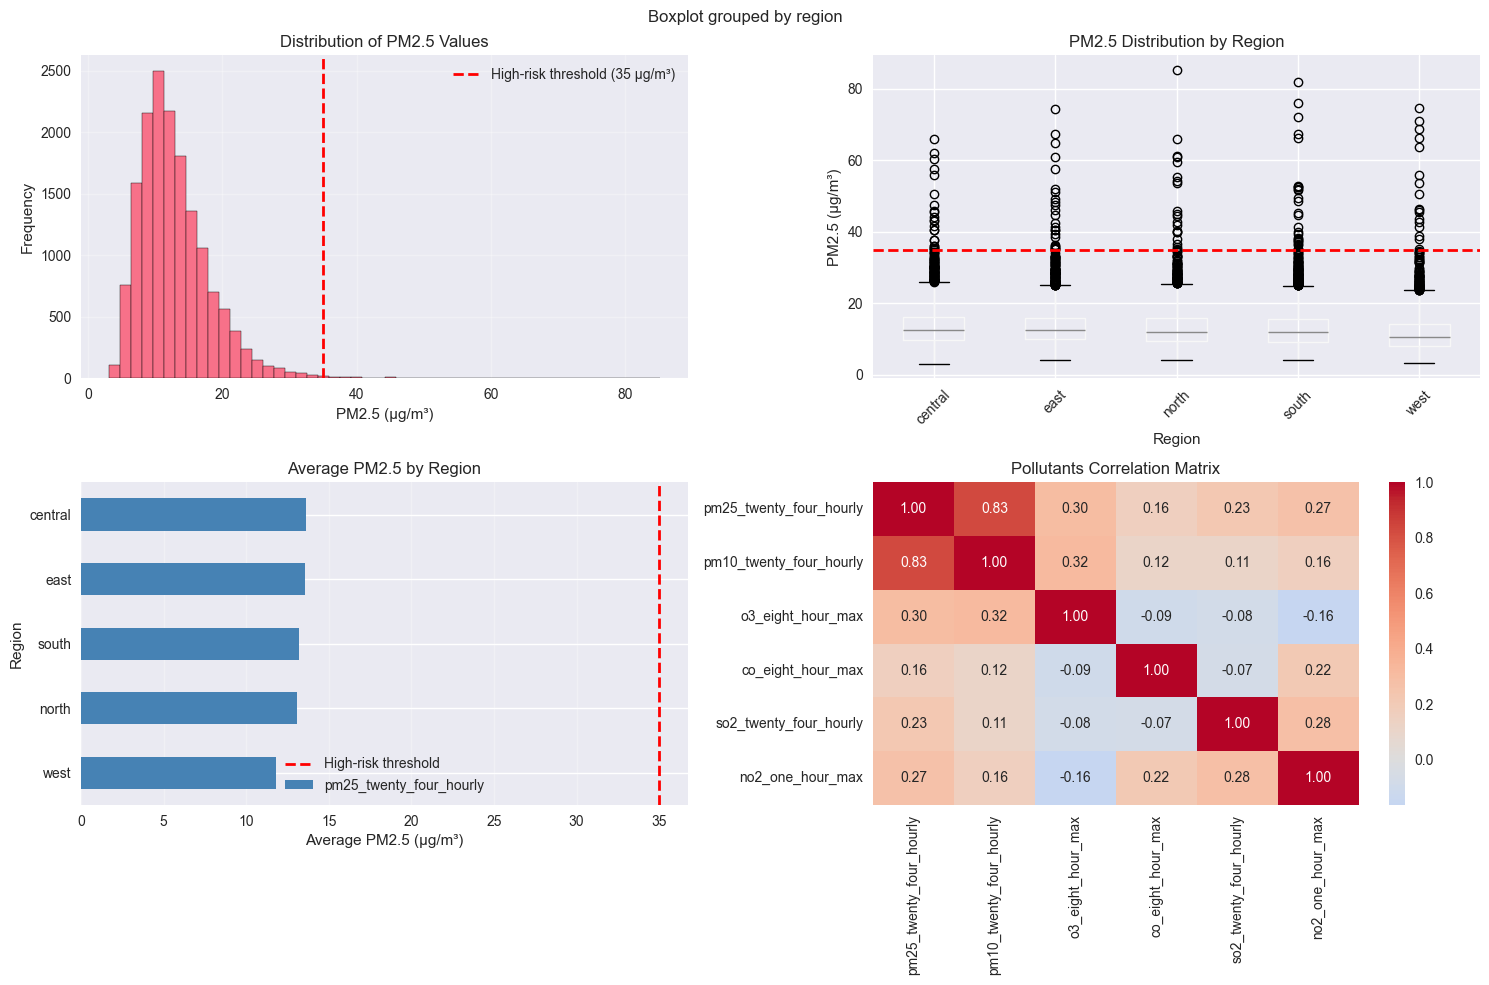

In [6]:
# Visualize PM2.5 distribution
if pollutants_clean is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Histogram of PM2.5 values
    ax1 = axes[0, 0]
    pollutants_clean['pm25_twenty_four_hourly'].hist(bins=50, ax=ax1, edgecolor='black')
    ax1.axvline(x=35, color='red', linestyle='--', linewidth=2, label='High-risk threshold (35 µg/m³)')
    ax1.set_xlabel('PM2.5 (µg/m³)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of PM2.5 Values')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plot by region
    ax2 = axes[0, 1]
    pollutants_clean.boxplot(column='pm25_twenty_four_hourly', by='region', ax=ax2)
    ax2.axhline(y=35, color='red', linestyle='--', linewidth=2, label='High-risk threshold')
    ax2.set_xlabel('Region')
    ax2.set_ylabel('PM2.5 (µg/m³)')
    ax2.set_title('PM2.5 Distribution by Region')
    plt.sca(ax2)
    plt.xticks(rotation=45)
    
    # 3. Average PM2.5 by region
    ax3 = axes[1, 0]
    region_avg_temp = pollutants_clean.groupby('region')['pm25_twenty_four_hourly'].mean()
    region_avg = region_avg_temp.sort_values(ascending=True)  # type: ignore
    region_avg.plot(kind='barh', ax=ax3, color='steelblue')
    ax3.axvline(x=35, color='red', linestyle='--', linewidth=2, label='High-risk threshold')
    ax3.set_xlabel('Average PM2.5 (µg/m³)')
    ax3.set_ylabel('Region')
    ax3.set_title('Average PM2.5 by Region')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='x')
    
    # 4. Correlation heatmap
    ax4 = axes[1, 1]
    pollutant_cols = ['pm25_twenty_four_hourly', 'pm10_twenty_four_hourly', 
                      'o3_eight_hour_max', 'co_eight_hour_max', 
                      'so2_twenty_four_hourly', 'no2_one_hour_max']
    # Calculate correlation matrix
    corr_data = pollutants_clean[pollutant_cols].corr()  # type: ignore
    sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax4, square=False)
    ax4.set_title('Pollutants Correlation Matrix')
    
    plt.tight_layout()
    
    # Save figure
    fig_path = viz_path / 'singapore_pollutants_analysis.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved visualization to: {fig_path}")
    
    plt.show()
else:
    print("Cannot create visualizations: pollutants data not available.")


## Step 4: Temperature Data Processing

Process temperature data from weather stations:
- Filter for Dry Bulb Temperature (DBT 1M F) readings
- Aggregate to daily station means
- Calculate national daily averages


In [7]:
def process_temperature_data(data_path, output_path):
    """
    Process air temperature data from 2016-2024
    - Load data from all weather stations
    - Filter for DBT 1M F (Dry Bulb Temperature) readings
    - Aggregate to daily mean per station
    - Calculate national daily mean
    """
    print("=== PROCESSING AIR TEMPERATURE DATA ===")
    
    temp_dir = data_path / 'air_temperature'
    all_data = []
    
    # Process each year's data
    for year in range(2016, 2025):
        file_path = temp_dir / f'airtemp_{year}.csv'
        if file_path.exists():
            print(f"\nProcessing {file_path.name}...")
            try:
                # Check file size
                file_size = file_path.stat().st_size / (1024 * 1024)  # MB
                print(f"  File size: {file_size:.1f} MB")
                
                # Load data in chunks if file is large
                if file_size > 100:
                    print(f"  Loading in chunks...")
                    chunks = []
                    for chunk in pd.read_csv(file_path, chunksize=100000):
                        # Filter for DBT 1M F readings
                        if 'reading_type' in chunk.columns:
                            chunk_filtered = chunk[chunk['reading_type'] == 'DBT 1M F'].copy()
                            if len(chunk_filtered) > 0:
                                chunks.append(chunk_filtered)
                    
                    if chunks:
                        df = pd.concat(chunks, ignore_index=True)
                    else:
                        print(f"  ✗ No DBT 1M F readings found")
                        continue
                else:
                    df = pd.read_csv(file_path)
                    # Filter for DBT 1M F readings
                    if 'reading_type' in df.columns:
                        df = df[df['reading_type'] == 'DBT 1M F'].copy()
                
                # Convert timestamp to datetime
                if 'timestamp' in df.columns:
                    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
                elif 'date' in df.columns:
                    df['timestamp'] = pd.to_datetime(df['date'], errors='coerce')
                
                # Extract date
                df['date'] = df['timestamp'].dt.date  # type: ignore
                
                # Convert reading value to numeric
                if 'reading_value' in df.columns:
                    df['reading_value'] = pd.to_numeric(df['reading_value'], errors='coerce')
                elif 'value' in df.columns:
                    df['reading_value'] = pd.to_numeric(df['value'], errors='coerce')
                
                # Get station name
                if 'station_name' in df.columns:
                    station_col = 'station_name'
                elif 'station' in df.columns:
                    station_col = 'station'
                else:
                    station_col = None
                
                if station_col:
                    df_subset = df[['date', station_col, 'reading_value']].copy()
                    df_subset.columns = ['date', 'station_name', 'reading_value']  # type: ignore
                else:
                    df_subset = df[['date', 'reading_value']].copy()
                    df_subset['station_name'] = 'Unknown'
                
                all_data.append(df_subset)
                print(f"  ✓ Loaded {len(df_subset):,} records")
                
            except Exception as e:
                print(f"  ✗ Error processing {file_path.name}: {e}")
        else:
            print(f"File not found: {file_path.name}")
    
    if not all_data:
        print("No temperature data found!")
        return None
    
    # Combine all years
    print("\n" + "="*50)
    print("Combining all years...")
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Total records: {len(combined_df):,}")
    
    # Daily aggregation by station
    print("\n" + "="*50)
    print("Performing daily aggregation by station...")
    daily_by_station = combined_df.groupby(['station_name', 'date']).agg({
        'reading_value': 'mean'
    }).reset_index()
    
    print(f"Daily station records: {len(daily_by_station):,}")
    print(f"Number of stations: {daily_by_station['station_name'].nunique()}")
    print(f"Date range: {daily_by_station['date'].min()} to {daily_by_station['date'].max()}")
    
    # Calculate national daily mean
    print("\n" + "="*50)
    print("Calculating national daily mean temperature...")
    national_daily = daily_by_station.groupby('date').agg({
        'reading_value': 'mean'
    }).reset_index()
    national_daily.columns = ['date', 'temperature_national']
    
    print(f"National daily records: {len(national_daily):,}")
    
    # Save processed data
    # Save station-level data
    station_output = output_path / 'airtemp_clean.csv'
    daily_by_station.to_csv(station_output, index=False)
    print(f"\n✓ Saved station-level temperature data to: {station_output}")
    
    # Save national-level data
    national_output = output_path / 'airtemp_national.csv'
    national_daily.to_csv(national_output, index=False)
    print(f"✓ Saved national-level temperature data to: {national_output}")
    
    return daily_by_station, national_daily

# Process temperature data
temp_station, temp_national = process_temperature_data(data_path, output_path)


=== PROCESSING AIR TEMPERATURE DATA ===

Processing airtemp_2016.csv...
  File size: 845.3 MB
  Loading in chunks...
  ✓ Loaded 5,844,707 records

Processing airtemp_2017.csv...
  File size: 1154.0 MB
  Loading in chunks...
  ✓ Loaded 7,971,714 records

Processing airtemp_2018.csv...
  File size: 1101.2 MB
  Loading in chunks...
  ✓ Loaded 7,631,448 records

Processing airtemp_2019.csv...
  File size: 1153.3 MB
  Loading in chunks...
  ✓ Loaded 7,998,257 records

Processing airtemp_2020.csv...
  File size: 1178.3 MB
  Loading in chunks...
  ✓ Loaded 8,159,209 records

Processing airtemp_2021.csv...
  File size: 1059.6 MB
  Loading in chunks...
  ✓ Loaded 7,281,038 records

Processing airtemp_2022.csv...
  File size: 1068.1 MB
  Loading in chunks...
  ✓ Loaded 7,355,149 records

Processing airtemp_2023.csv...
  File size: 994.4 MB
  Loading in chunks...
  ✓ Loaded 6,893,129 records

Processing airtemp_2024.csv...
  File size: 992.1 MB
  Loading in chunks...
  ✓ Loaded 6,868,395 records


### 4.1 Temperature Data Summary


=== NATIONAL TEMPERATURE DATA SUMMARY ===
Shape: (3114, 2)

First 10 rows:


,date,temperature_national
0,2016-04-15,29.773682
1,2016-04-29,28.089879
2,2016-04-30,27.504449
3,2016-05-05,29.013313
4,2016-05-06,30.034486
5,2016-05-07,29.289446
6,2016-05-08,29.377301
7,2016-05-09,29.156726
8,2016-06-01,27.627312
9,2016-06-02,28.311114



Basic statistics:


,temperature_national
count,3114.000000
mean,28.040071
std,1.118200
min,22.973480
25%,27.311804
50%,28.069713
75%,28.856660
max,30.676974



Missing values:
date                    0
temperature_national    0
dtype: int64

✓ Saved visualization to: /Users/sharin/Downloads/COS30049/Assignment/Assignment_2/AirAware/visualizations/singapore_temperature_analysis.png


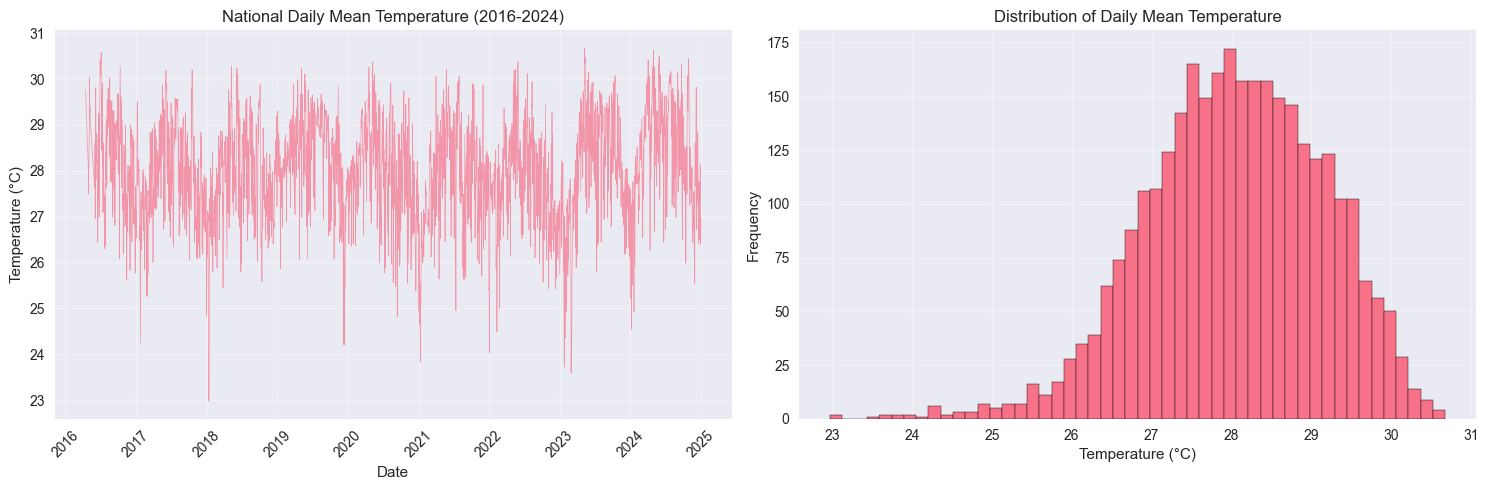

In [8]:
# Display summary of temperature data
if temp_national is not None:
    print("=== NATIONAL TEMPERATURE DATA SUMMARY ===")
    print(f"Shape: {temp_national.shape}")
    print(f"\nFirst 10 rows:")
    display(temp_national.head(10))
    
    print(f"\nBasic statistics:")
    display(temp_national.describe())
    
    print(f"\nMissing values:")
    missing = temp_national.isnull().sum()
    print(missing)
    
    # Visualize temperature over time
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Time series plot
    ax1 = axes[0]
    temp_national_sorted = temp_national.sort_values('date')  # type: ignore
    ax1.plot(temp_national_sorted['date'], temp_national_sorted['temperature_national'], 
             linewidth=0.5, alpha=0.7)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('National Daily Mean Temperature (2016-2024)')
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Distribution histogram
    ax2 = axes[1]
    temp_national['temperature_national'].hist(bins=50, ax=ax2, edgecolor='black')
    ax2.set_xlabel('Temperature (°C)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Daily Mean Temperature')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    fig_path = viz_path / 'singapore_temperature_analysis.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved visualization to: {fig_path}")
    
    plt.show()
else:
    print("Error: Temperature data could not be processed.")


## Step 5: Weather Forecast Processing

Map forecast text/codes to numerical categories (1-5) and aggregate to daily national averages.

**Category Scale:**
1. Excellent (clear)
2. Good (fair, sunny)
3. Neutral (partly cloudy)
4. Poor (rain, cloudy)
5. Severe (thunderstorms, heavy rain)


In [9]:
def map_forecast_to_category(forecast_text, forecast_code):
    """
    Map forecast text/code to numerical category (1-5)
    """
    if pd.isna(forecast_text) and pd.isna(forecast_code):
        return None
    
    # Convert to lowercase for matching
    text = str(forecast_text).lower() if not pd.isna(forecast_text) else ""
    code = str(forecast_code).upper() if not pd.isna(forecast_code) else ""
    
    # Category 5: Severe weather
    if any(word in text for word in ['thunderstorm', 'heavy rain', 'heavy shower', 'storm']):
        return 5
    if code in ['HT', 'HR']:  # Heavy Thunderstorm, Heavy Rain
        return 5
    
    # Category 4: Poor weather
    if any(word in text for word in ['rain', 'shower', 'drizzle', 'cloudy', 'overcast']):
        return 4
    if code in ['LR', 'SH', 'CL', 'OC', 'LH']:  # Light Rain, Shower, Cloudy, Overcast, Light Shower
        return 4
    
    # Category 3: Neutral weather
    if any(word in text for word in ['partly cloudy', 'hazy', 'mist', 'fog']):
        return 3
    if code in ['PC', 'HZ', 'BR', 'FG']:  # Partly Cloudy, Hazy, Mist, Fog
        return 3
    
    # Category 2: Good weather
    if any(word in text for word in ['fair', 'sunny', 'bright']):
        return 2
    if code in ['FA', 'SU']:  # Fair, Sunny
        return 2
    
    # Category 1: Excellent weather
    if any(word in text for word in ['clear', 'perfect']):
        return 1
    
    # Default to category 3 (neutral) if unknown
    return 3

def process_weather_forecast_data(data_path, output_path):
    """
    Process weather forecast data from 2016-2024
    - Load forecast data
    - Map forecast text/code to numerical categories
    - Aggregate to daily forecast category per location
    - Calculate national daily average
    """
    print("=== PROCESSING WEATHER FORECAST DATA ===")
    
    forecast_dir = data_path / 'weather_forecast'
    all_data = []
    
    # Process each year's data
    for year in range(2016, 2025):
        file_path = forecast_dir / f'forecast_{year}.csv'
        if file_path.exists():
            print(f"\nProcessing {file_path.name}...")
            try:
                # Check file size
                file_size = file_path.stat().st_size / (1024 * 1024)  # MB
                print(f"  File size: {file_size:.1f} MB")
                
                # Load data in chunks if file is large
                if file_size > 100:
                    print(f"  Loading in chunks...")
                    chunks = []
                    for chunk in pd.read_csv(file_path, chunksize=100000):
                        chunks.append(chunk)
                    df = pd.concat(chunks, ignore_index=True)
                else:
                    df = pd.read_csv(file_path)
                
                # Convert timestamp to datetime
                if 'timestamp' in df.columns:
                    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
                elif 'date' in df.columns:
                    df['timestamp'] = pd.to_datetime(df['date'], errors='coerce')
                
                # Extract date
                df['date'] = df['timestamp'].dt.date  # type: ignore
                
                # Map forecast to category
                if 'forecast_text' in df.columns and 'forecast_code' in df.columns:
                    df['forecast_category'] = df.apply(
                        lambda row: map_forecast_to_category(row['forecast_text'], row['forecast_code']), 
                        axis=1
                    )
                elif 'forecast' in df.columns:
                    df['forecast_category'] = df.apply(
                        lambda row: map_forecast_to_category(row['forecast'], None), 
                        axis=1
                    )
                else:
                    print(f"  ✗ No forecast columns found")
                    continue
                
                # Get location name
                if 'location_name' in df.columns:
                    location_col = 'location_name'
                elif 'location' in df.columns:
                    location_col = 'location'
                else:
                    location_col = None
                
                if location_col:
                    df_subset = df[['date', location_col, 'forecast_category']].copy()
                    df_subset.columns = ['date', 'location_name', 'forecast_category']  # type: ignore
                else:
                    df_subset = df[['date', 'forecast_category']].copy()
                    df_subset['location_name'] = 'Unknown'
                
                all_data.append(df_subset)
                print(f"  ✓ Loaded {len(df_subset):,} records")
                
            except Exception as e:
                print(f"  ✗ Error processing {file_path.name}: {e}")
        else:
            print(f"File not found: {file_path.name}")
    
    if not all_data:
        print("No weather forecast data found!")
        return None
    
    # Combine all years
    print("\n" + "="*50)
    print("Combining all years...")
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Total records: {len(combined_df):,}")
    
    # Daily aggregation by location (mode of category)
    print("\n" + "="*50)
    print("Performing daily aggregation by location...")
    daily_by_location = combined_df.groupby(['location_name', 'date']).agg({
        'forecast_category': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean()
    }).reset_index()
    
    print(f"Daily location records: {len(daily_by_location):,}")
    print(f"Number of locations: {daily_by_location['location_name'].nunique()}")
    print(f"Date range: {daily_by_location['date'].min()} to {daily_by_location['date'].max()}")
    
    # Calculate national daily average
    print("\n" + "="*50)
    print("Calculating national daily average forecast category...")
    national_daily = daily_by_location.groupby('date').agg({
        'forecast_category': 'mean'
    }).reset_index()
    national_daily.columns = ['date', 'forecast_category_national']  # type: ignore
    
    print(f"National daily records: {len(national_daily):,}")
    
    # Save processed data
    # Save location-level data
    location_output = output_path / 'weather_forecast_clean.csv'
    daily_by_location.to_csv(location_output, index=False)
    print(f"\n✓ Saved location-level forecast data to: {location_output}")
    
    # Save national-level data
    national_output = output_path / 'weather_forecast_national.csv'
    national_daily.to_csv(national_output, index=False)
    print(f"✓ Saved national-level forecast data to: {national_output}")
    
    return daily_by_location, national_daily

# Process weather forecast data
forecast_location, forecast_national = process_weather_forecast_data(data_path, output_path)


=== PROCESSING WEATHER FORECAST DATA ===

Processing forecast_2016.csv...
  File size: 119.8 MB
  Loading in chunks...
  ✓ Loaded 711,110 records

Processing forecast_2017.csv...
  File size: 143.1 MB
  Loading in chunks...
  ✓ Loaded 845,154 records

Processing forecast_2018.csv...
  File size: 164.4 MB
  Loading in chunks...
  ✓ Loaded 970,221 records

Processing forecast_2019.csv...
  File size: 170.4 MB
  Loading in chunks...
  ✓ Loaded 1,004,672 records

Processing forecast_2020.csv...
  File size: 155.3 MB
  Loading in chunks...
  ✓ Loaded 918,333 records

Processing forecast_2021.csv...
  File size: 167.6 MB
  Loading in chunks...
  ✓ Loaded 988,034 records

Processing forecast_2022.csv...
  File size: 175.0 MB
  Loading in chunks...
  ✓ Loaded 1,036,914 records

Processing forecast_2023.csv...
  File size: 169.6 MB
  Loading in chunks...
  ✓ Loaded 1,004,484 records

Processing forecast_2024.csv...
  File size: 187.3 MB
  Loading in chunks...
  ✓ Loaded 1,109,764 records

Combi

### 5.1 Weather Forecast Summary


=== NATIONAL WEATHER FORECAST DATA SUMMARY ===
Shape: (3085, 2)

First 10 rows:


,date,forecast_category_national
0,2016-03-14,4.0
1,2016-03-15,2.0
2,2016-03-16,2.0
3,2016-03-17,2.0
4,2016-03-18,2.0
5,2016-03-19,2.0
6,2016-03-20,4.0
7,2016-03-21,4.0
8,2016-03-22,4.0
9,2016-03-23,4.0



Basic statistics:


,forecast_category_national
count,3085.000000
mean,3.782351
std,0.591002
min,2.000000
25%,4.000000
50%,4.000000
75%,4.000000
max,4.276596



Missing values:
date                          0
forecast_category_national    0
dtype: int64

✓ Saved visualization to: /Users/sharin/Downloads/COS30049/Assignment/Assignment_2/AirAware/visualizations/singapore_forecast_analysis.png


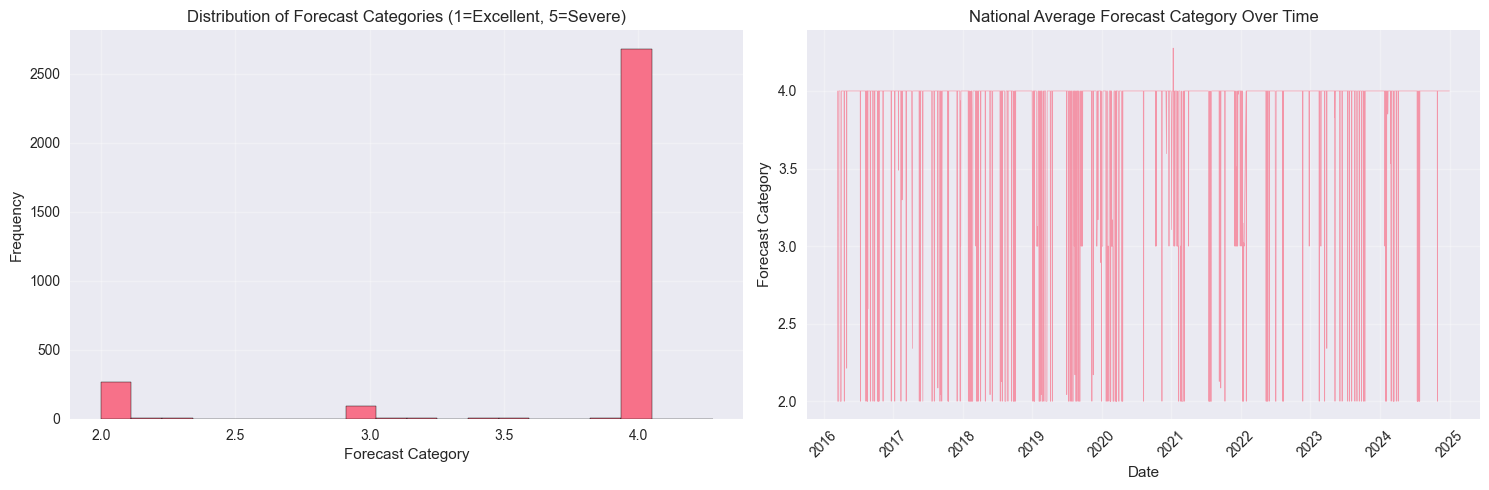

In [10]:
# Display summary of weather forecast data
if forecast_national is not None:
    print("=== NATIONAL WEATHER FORECAST DATA SUMMARY ===")
    print(f"Shape: {forecast_national.shape}")
    print(f"\nFirst 10 rows:")
    display(forecast_national.head(10))
    
    print(f"\nBasic statistics:")
    display(forecast_national.describe())
    
    print(f"\nMissing values:")
    missing = forecast_national.isnull().sum()
    print(missing)
    
    # Visualize forecast categories
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Category distribution
    ax1 = axes[0]
    forecast_national['forecast_category_national'].hist(bins=20, ax=ax1, edgecolor='black')
    ax1.set_xlabel('Forecast Category')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Forecast Categories (1=Excellent, 5=Severe)')
    ax1.grid(True, alpha=0.3)
    
    # Time series of forecast
    ax2 = axes[1]
    forecast_national_sorted = forecast_national.sort_values('date')  # type: ignore
    ax2.plot(forecast_national_sorted['date'], forecast_national_sorted['forecast_category_national'], 
             linewidth=0.5, alpha=0.7)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Forecast Category')
    ax2.set_title('National Average Forecast Category Over Time')
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    
    # Save figure
    fig_path = viz_path / 'singapore_forecast_analysis.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved visualization to: {fig_path}")
    
    plt.show()
else:
    print("Error: Weather forecast data could not be processed.")


## Summary

Data cleaning completed for Singapore (2016-2024).

**Output Files:**
- `pollutants_clean.csv` - Daily pollutant levels by region
- `airtemp_clean.csv` / `airtemp_national.csv` - Temperature data
- `weather_forecast_clean.csv` / `weather_forecast_national.csv` - Forecast categories
